# K-means Clustering

### Import resources and display image

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

BLUE = (0,0,255)
RED = (255,0,0)

### Read in an image

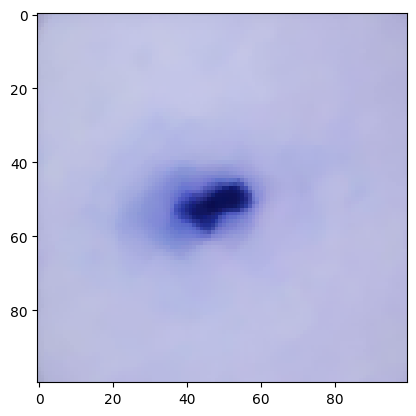

In [2]:
image = cv2.imread("image/Segmented_Images_Labeled/Segmented_Images_Labeled/Folder0_Target_0/_initial.PNG")
plt.imshow(image)

### Change from BGR to RGB

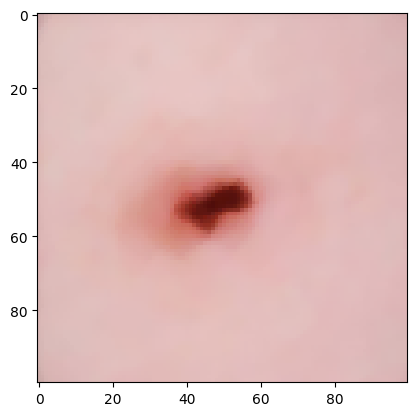

In [3]:
# Change color to RGB (from BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

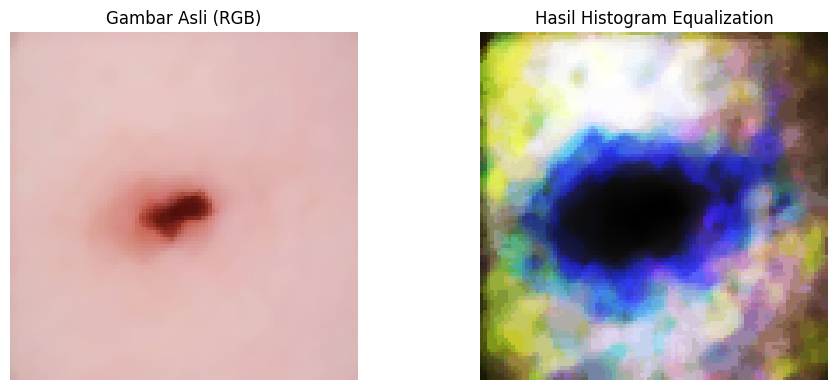

In [4]:
b, g, r = cv2.split(image)

b_eq = cv2.equalizeHist(b)
g_eq = cv2.equalizeHist(g)
r_eq = cv2.equalizeHist(r)

equalized_color = cv2.merge((b_eq, g_eq, r_eq))
equalized_color_rgb = cv2.cvtColor(equalized_color, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Gambar Asli (RGB)')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Hasil Histogram Equalization')
plt.imshow(equalized_color_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

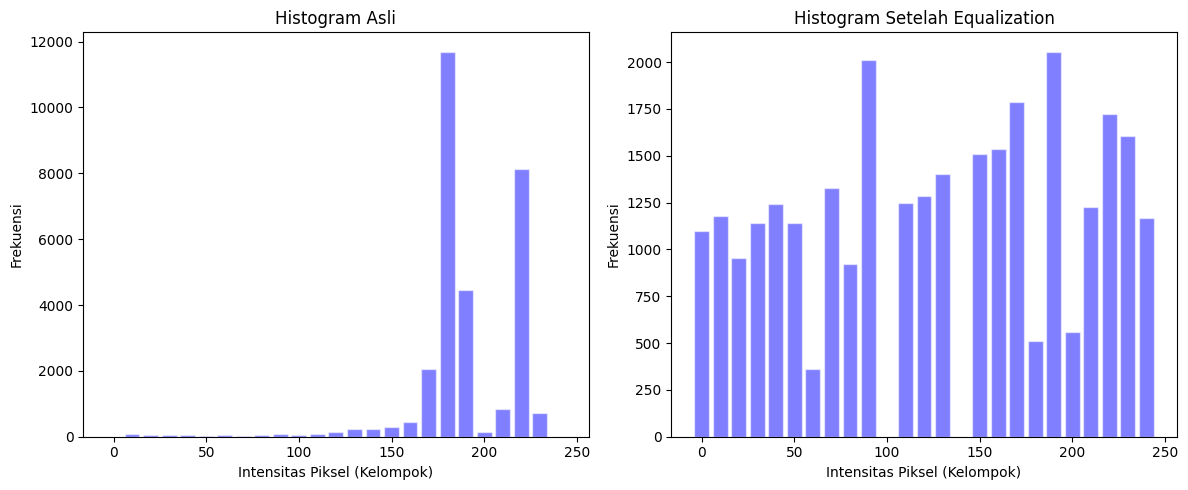

In [5]:
bin_size = 10
bins = np.arange(0, 256, bin_size)
hist_original, _ = np.histogram(image, bins=bins)
hist_equalized, _ = np.histogram(equalized_color_rgb, bins=bins)

# Plot histogram
plt.figure(figsize=(12, 5))

# Histogram Asli
plt.subplot(1, 2, 1)
plt.bar(bins[:-1], hist_original, width=8, color='blue', edgecolor='white', alpha=0.5)
plt.title("Histogram Asli")
plt.xlabel("Intensitas Piksel (Kelompok)")
plt.ylabel("Frekuensi")
plt.xticks(np.arange(0, 256, 50)) 

# Histogram Setelah Equalization
plt.subplot(1, 2, 2)
plt.bar(bins[:-1], hist_equalized, width=8, color='blue', edgecolor='white', alpha=0.5)
plt.title("Histogram Setelah Equalization")
plt.xlabel("Intensitas Piksel (Kelompok)")
plt.ylabel("Frekuensi")
plt.xticks(np.arange(0, 256, 50))

plt.tight_layout()
plt.show()

### Reshape image to 2d array

In [6]:
pixel_vals = equalized_color_rgb.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)

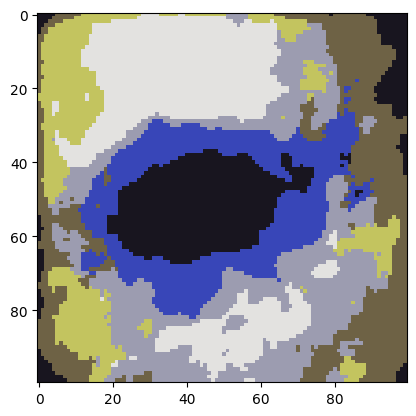

In [7]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

k = 6
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]

segmented_image = segmented_data.reshape((image.shape))
labels_reshape = labels.reshape(image.shape[0], image.shape[1])

plt.imshow(segmented_image)

### Mask image by cluster

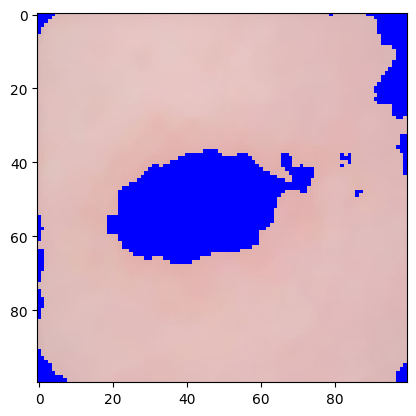

In [8]:
cluster = 4
masked_image = np.copy(image)
masked_image[labels_reshape == cluster] = [BLUE]

plt.imshow(masked_image)

In [9]:
print(masked_image.shape)

(100, 100, 3)
